This is the principal notebook where are described the Baseline and the Multiple Choice implementations.

In [ ]:
! pip install transformers

In [ ]:
import transformers
from transformers import (
    AutoTokenizer,
    BertModel,
    logging
)
from transformers.tokenization_utils_base import PreTrainedTokenizerBase

import numpy as np
import pandas as pd

import os
import random
import time
import math
import yaml
from typing import *
from datetime import datetime
from collections import namedtuple

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler

SEED = 10

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

# Display the entire text
pd.set_option("display.max_colwidth", None)
logging.set_verbosity_error()

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
device

device(type='cuda')

In [ ]:
# For Colab
from google.colab import drive
drive.mount('/content/drive/')

curr_location = "/content/drive/MyDrive/Colab Notebooks/Deep Learning/NLP/nlp2022-hw3/hw3/stud/"
os.chdir(curr_location)

Mounted at /content/drive/


In [ ]:
curr_location = "H:/My Drive/Colab Notebooks/Deep Learning/NLP/nlp2022-hw3/hw3/stud"
os.chdir(curr_location)

In [ ]:
from arguments import *

I defined custom arguments for the model and the training process in the arguments.py, by taking inspiration from the Hugginface [TrainingArguments](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) class.


In this way, all the arguments will be read from this file and it is therefore easy to organized them. Moreover, using [HfArgumentParser](https://huggingface.co/docs/transformers/v4.21.3/en/internal/trainer_utils#transformers.HfArgumentParser) we can turn these classes
into argparse arguments to be able to specify them on
the command line.

In [ ]:
yaml_file = "./train_notebook2.yaml"
# Read configuration file with all the necessary parameters
with open(yaml_file) as file:
    config = yaml.safe_load(file)
    
model_args = ModelArguments(**config['model_args'])
model_name_or_path = model_args.model_name_or_path
model_name_or_path

'bert-large-uncased'

In [ ]:
train_clean_path = "../../model/data/train_clean.tsv"
valid_clean_path = "../../model/data/valid_clean.tsv"

In [ ]:
df_train = pd.read_csv(filepath_or_buffer=train_clean_path, sep="\t")
df_valid = pd.read_csv(filepath_or_buffer=valid_clean_path, sep="\t")

The `GAP_Dataset` class has many configuration parameters, since I have tried different approaches. I decided not to split the class in different subclasses because a particular configuration only requires to change few lines of code. 

The idea behind the **multiple choice** dataset is taken from the paper [Gendered Pronoun Resolution using BERT and an Extractive Question Answering Formulation](https://aclanthology.org/W19-3819.pdf).


In the **multiple choice** approach, each sample feature is composed by *num_choices* lists (in this case 3), where an option has the following structure:
    
CLS + context + SEP + ambiguous pronoun "is" + option + SEP

where:
- **context** is the text passage
- **option** is one of A’s name, B’s name or the word "neither" if the pronoun in the example doesn’t co-refer with A and B.

In [ ]:
class GAP_Dataset(Dataset):
    """
    Custom GAP dataset for multiple choice or sequence classfication.
    
    Parameters
    ----------
    df: pd.DataFrame
        A dataframe from the GAP dataset.
        
    tokenizer: PreTrainedTokenizerBase
        The tokenizer used to preprocess the data.
        
    tag_labels: Dict[str, str]
        A dictionary containing as values the tags that will be inserted
        to delimit an entity or a pronoun.
        
    multiple_choice: bool
        Whether to instantiate a dataset for multiple choice
        classification or not.
        
    keep_tags: bool
        If true the tags added to text are kept even after
        the tokenization process.
        
    truncate_up_to_pron: bool
        If false the text is not truncated. 
        Otherwise, the text will be truncated at the last tag inserted, 
        that can delimit either an entity or the amiguous pronoun, 
        with the addition of the ambigous pronoun at the end.
  
    labeled: bool
        If the dataset also contains the labels.
        
    cleaned: bool
        Whether the GAP dataframe is already cleaned or not.
    """
    def __init__(
        self, 
        df: pd.DataFrame, 
        tokenizer: PreTrainedTokenizerBase, 
        tag_labels: Dict[str, str], 
        multiple_choice: bool=False,
        keep_tags: bool=False, 
        truncate_up_to_pron: bool=True, 
        labeled: bool=True, 
        cleaned: bool=True
    ):
        
        if not cleaned:
             self.clean_dataframe(df)

        self.df = df
        self.tokenizer = tokenizer
        self.multiple_choice = multiple_choice
        self.keep_tags = keep_tags
        self.truncate_up_to_pron = truncate_up_to_pron
        self.labeled = labeled
        
        self.tag_labels = tag_labels
        self._init_tag_labels()
        
        self.samples = []
        self._convert_tokens_to_ids()
        
    @staticmethod
    def clean_text(text: str):
        text = text.translate(str.maketrans("`", "'"))
        return text

    def clean_dataframe(self, df: pd.DataFrame):
        df['text'] = df['text'].map(self.clean_text)
        df['entity_A'] = df['entity_A'].map(self.clean_text) 
        df['entity_B'] = df['entity_B'].map(self.clean_text) 
        
    
    def _init_tag_labels(self):
        self.pronoun_tag = self.tag_labels['pronoun_tag']
        self.start_A_tag = self.tag_labels['start_A_tag']
        self.end_A_tag = self.tag_labels['end_A_tag']
        self.start_B_tag = self.tag_labels['start_B_tag']
        self.end_B_tag = self.tag_labels['end_B_tag']


    @staticmethod
    def get_class_id(is_coref_A: Union[str, bool], is_coref_B: Union[str, bool]) -> int:
        """
        Returns
        -------
            An integer representing the class of a input sentence.
            The class id is:
            - 0 if the pronoun references entity A
            - 1 if the pronoun references entity B
            - 2 if the pronoun references neither A nor B
        """
        if is_coref_A in ["TRUE", True]:
            return 0
        elif is_coref_B in ["TRUE", True]:
            return 1
        else:
            return 2
        
    def _convert_tokens_to_ids(self):
        CLS = [self.tokenizer.cls_token]
        SEP = [self.tokenizer.sep_token]

        Sample = namedtuple("Sample", ['tokens', 'offsets'])
        if self.labeled:
            Sample = namedtuple("Sample", Sample._fields + ("labels",))

        for _, row in self.df.iterrows():
            tokens, offsets = self._tokenize(row)
            
            if self.multiple_choice:
                final_tokens = self._create_multiple_choices(tokens, offsets)
            else:
                tokens_to_convert = CLS + tokens + SEP
                final_tokens = self.tokenizer.convert_tokens_to_ids(tokens_to_convert)
                
            sample = {'tokens': final_tokens,
                      'offsets': self._get_offsets_list(offsets)}

            if self.labeled:
                sample['labels'] = self.get_class_id(row['is_coref_A'], row['is_coref_B'])

            sample_namedtuple = Sample(**sample)
            self.samples.append(sample_namedtuple)

            
    def _create_multiple_choices(self, tokens: List[int], offsets: Dict[str, List[int]]) -> List[int]:
        CLS = [self.tokenizer.cls_token]
        SEP = [self.tokenizer.sep_token]
        
        pronoun = tokens[offsets[self.pronoun_tag][0]]
        A_entity = tokens[offsets[self.start_A_tag][0]:offsets[self.end_A_tag][0]]
        B_entity = tokens[offsets[self.start_B_tag][0]:offsets[self.end_B_tag][0]]
        
        final_tokens = []
        
        first = CLS + tokens + SEP + [pronoun, "is"] + A_entity + SEP
        second = CLS + tokens + SEP + [pronoun, "is"] + B_entity + SEP   
        third = CLS + tokens + SEP + [pronoun, "is", "neither"] + SEP
        
        tokens_to_convert = [first, second, third]
        final_tokens = [self.tokenizer.convert_tokens_to_ids(choice) for choice in tokens_to_convert]

        return final_tokens
    

    def _get_offsets_list(self, offsets: Dict[str, List[int]]) -> List[int]:
        # 1 is added for the introduction of the CLS token
        offsets_A = [offsets[self.start_A_tag][0] + 1, offsets[self.end_A_tag][0] + 1]
        offsets_B = [offsets[self.start_B_tag][0] + 1, offsets[self.end_B_tag][0] + 1]

        return offsets_A + offsets_B + [offsets[self.pronoun_tag][0] + 1] 

        
    def _insert_tag(self, text: str, offsets: Tuple[int, int], 
                    start_tag: str, end_tag: str = None) -> str:
        start_off, end_off = offsets 

        # Starting tag only
        if end_tag is None:
            text = text[:start_off] + start_tag + text[start_off:]
            return text

        text = text[:start_off] + start_tag + text[start_off:end_off] + end_tag + text[end_off:]
        return text

    """
    The methods '_delimit_mentions' and '_tokenize' are inspired 
    by the work of `rakeshchada` in the repository 
    "https://github.com/rakeshchada/corefqa/blob/master/CorefSeq.ipynb"
    """
    def _delimit_mentions(self, row: pd.Series) -> str:
        text = row['text']
        pronoun = row['pron']
        A_entity = row['entity_A']
        B_entity = row['entity_B']

        # Sort the offsets in ascending order
        break_points = sorted([
            (self.pronoun_tag, row['p_offset']),
            (self.start_A_tag, row['offset_A']),
            (self.end_A_tag, row['offset_A'] + len(A_entity)),
            (self.start_B_tag, row['offset_B']),
            (self.end_B_tag, row['offset_B'] + len(B_entity)),
        ], key=lambda x: x[1])

        # When a new tag is inserted, the offset of the next tag
        # changes by the length of the inserted tag.
        len_added_tags = 0
        for tag, offset in break_points:
            offset += len_added_tags
            text = self._insert_tag(text, (offset, None), tag)
            len_added_tags += len(tag)

        # Truncate the text at the last tag inserted and append the pronoun at the end
        if self.truncate_up_to_pron:
            text = text[:offset+len(tag)] + pronoun
        
        return text

    def _tokenize(self, row: pd.Series) -> Tuple[List[int], Dict[str, List[int]]]: 
        """
        Tokenize the text.
        If keep_tags is True, also the tags are tokenized.
        """
        
        tokens = []
        tag_labels = self.tag_labels
        offsets = {tag: [] for tag in tag_labels.values()}

        text = self._delimit_mentions(row)

        # Also the tags are added to the tokens
        if self.keep_tags:
            for token in self.tokenizer.tokenize(text):    
                tokens.append(token)

                if token in [*tag_labels.values()]:
                    if "/" in token: # End token
                        offsets[token].append(len(tokens)-1)
                    else:
                        offsets[token].append(len(tokens)) 
        
        # The tags are skipped
        else:
            for token in self.tokenizer.tokenize(text):              
                if token in [*tag_labels.values()]:
                    offsets[token].append(len(tokens)) 
                    continue
                tokens.append(token)
        
        return tokens, offsets

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [ ]:
tag_labels = {
    "pronoun_tag": "<p>",
    "start_A_tag": "<a>",
    "end_A_tag": "</a>",
    "start_B_tag": "<b>",
    "end_B_tag": "</b>"
}

In [ ]:
tokenizer_name_or_path = model_args.tokenizer
if tokenizer_name_or_path is None:
    tokenizer_name_or_path = model_name_or_path
tokenizer_name_or_path

'bert-large-uncased'

I specify to the tokenizer not to split the tag labels that will be used to delimit the relevant tokens, such as entities and the pronoun.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name_or_path, never_split=list(tag_labels.values()))
tokenizer.add_tokens(list(tag_labels.values()), special_tokens=True)

In [ ]:
train_ds = GAP_Dataset(df_train, tokenizer, tag_labels)
valid_ds = GAP_Dataset(df_valid, tokenizer, tag_labels)

In [ ]:
train_ds = GAP_Dataset(df_train, tokenizer, tag_labels, multiple_choice=True)
valid_ds = GAP_Dataset(df_valid, tokenizer, tag_labels, multiple_choice=True)

In [ ]:
def compute_max_len(sequences: Union[List[List[int]], Tuple[List[int]]], truncate_len: int) -> int:
    """
    Computes the maximum length in the sequences.         
    """
    max_len = min(
        max((len(x) for x in sequences)),
        truncate_len
    )
    return max_len
    
def pad_sequence(sequences: Union[List[List[int]], Tuple[List[int]]], max_len: int, pad: int) -> np.ndarray:
    """
    Returns
    -------
        A numpy array padded with the 'pad' value until 
        the 'max_len' length. 

    Parameters
    ----------
    sequences: Union[List[List[int]], Tuple[List[int]]]
        A list or tuple of lists. 

    max_len: int
        The length to which the input is padded.

    pad: int
        The padding value.
    """
    array_sequences = np.full((len(sequences), max_len), pad, dtype=np.int64)

    # Padding
    for i, sequence in enumerate(sequences):
        array_sequences[i, :len(sequence)] = sequence

    return array_sequences

In [ ]:
class Collator:
    """
    Collator for Sequence Classification.
    
    Returns
    -------
        A dictionary of tensors of the batch sequences in input.

    Parameters
    ----------
    device: str
        Where (CPU/GPU) to load the features.
        
    pad: int
        The padding value.

    truncate_len: int
        Maximum length possible in the batch.

    labeled: bool
        If the batch also contains the labels.
    """
    def __init__(self, device: str, pad: int=0, 
                 truncate_len: int=512, labeled=True):
        self.device = device
        self.pad = pad
        self.truncate_len = truncate_len
        self.labeled = labeled

    def __call__(self, batch: list) -> Dict[str, torch.Tensor]:
        
        if self.labeled:
            batch_features, batch_offsets, batch_labels = zip(*batch)

        else:
            batch_features, batch_offsets = zip(*batch)

        max_len = compute_max_len(batch_features, self.truncate_len)

        collate_sample = {}

        # Features
        padded_features = pad_sequence(batch_features, max_len, self.pad)
        features_tensor = torch.tensor(padded_features, device=self.device)
        collate_sample['features'] = features_tensor

        # Offsets
        offsets_tensor = torch.tensor(batch_offsets, device=self.device)
        collate_sample['offsets'] = offsets_tensor

        if not self.labeled:
            return collate_sample

        # Labels
        labels_tensor = torch.tensor(
            batch_labels, dtype=torch.uint8, device=self.device)
        collate_sample['labels'] = labels_tensor

        return collate_sample

The collator for multiple choice classification has to flatten the input features in order to pad/truncate the lists. After those operations the features are reshape to the original shape, i.e., `[bacth_size, num_choices]`.

In [ ]:
class Collator_Multi_Choice:
    """
    Collator for Multiple Choice Classification.
    
    Returns
    -------
        A dictionary of tensors of the batch sequences in input.

    Parameters
    ----------
    device: str
        Where (CPU/GPU) to load the features.
        
    pad: int
        The padding value.

    truncate_len: int
        Maximum length possible in the batch.

    labeled: bool
        If the batch also contains the labels.
    """
    def __init__(self, device: str, pad: int=0, 
                 truncate_len: int=512, labeled=True):
        self.device = device
        self.pad = pad
        self.truncate_len = truncate_len
        self.labeled = labeled
        
    def __call__(self, batch: list) -> Dict[str, torch.Tensor]:
        if self.labeled:
            batch_features, _, batch_labels = zip(*batch)

        else:
            batch_features, _ = zip(*batch)
        
        batch_size = len(batch_features)
        num_choices = len(batch_features[0])

        collate_sample = {}

        # Features
        # batch_features shape: batch_size x num_choices
        flattened_batch_features = sum(batch_features, [])
        # flattened_batch_features shape: batch_size * num_choices
        max_len = compute_max_len(flattened_batch_features, self.truncate_len)

        padded_flattened_features = pad_sequence(flattened_batch_features, max_len, self.pad)
        flattened_features_tensor = torch.tensor(padded_flattened_features, device=self.device)
        features_tensor = flattened_features_tensor.view(batch_size, num_choices, -1)

        collate_sample['features'] = features_tensor

        if not self.labeled:
            return collate_sample

        # Labels
        labels_tensor = torch.tensor(
            batch_labels, dtype=torch.uint8, device=self.device)
        collate_sample['labels'] = labels_tensor

        return collate_sample

In [ ]:
class Entity_Resolution_Head(nn.Module):
    def __init__(self, bert_hidden_size: int, args: ModelArguments):
        super().__init__()

        self.args = args
        self.bert_hidden_size = bert_hidden_size

        
        input_size = bert_hidden_size * 3
        if args.output_strategy == "concat":
            input_size *= 4
        
        self.ffnn = nn.Sequential(
            nn.Linear(input_size, args.head_hidden_size),
            nn.BatchNorm1d(args.head_hidden_size),
            nn.LeakyReLU(),
            nn.Dropout(args.dropout),
        )
        
        self.classifier = nn.Linear(args.head_hidden_size, args.num_output)

    def forward(self, bert_outputs, offsets):
        assert bert_outputs.shape[2] == self.bert_hidden_size
        embeddings = self._retrieve_entities_and_pron_embeddings(bert_outputs,
                                                           offsets)

        x = self.ffnn(embeddings)
        output = self.classifier(x)
        return output
    
    def _retrieve_entities_and_pron_embeddings(self, bert_embeddings: torch.Tensor,
                                               entities_and_pron_offsets: torch.Tensor):
        
        # bert_embeddings shape: batch_size x seq_length x embed_dim
        # entities_and_pron_offsets shape: batch_size x 5
        
        embeddings_A = []
        embeddings_B = []
        embeddings_pron = []

        # Consider embeddings and offsets in each batch separately
        for embeddings, off in zip(bert_embeddings, entities_and_pron_offsets):
            # The offsets of mention A are the first and the second
            # in the 'off' tensor
            offsets_ent_A = range(off[0], off[1])
            # The offsets of mention B are the third and the fourth
            # in the 'off' tensor
            offsets_ent_B = range(off[2], off[3])
            # The offset of the pronoun is the last in the 'off' tensor
            offset_pron = off[-1]

            # The embedding of a mention is the mean of
            # all the subtokens embeddings that represent it
            embeddings_A.append(embeddings[offsets_ent_A].mean(dim=0))
            embeddings_B.append(embeddings[offsets_ent_B].mean(dim=0))
            embeddings_pron.append(embeddings[offset_pron])

        # Merge outputs
        merged_entities_and_pron_embeddings = torch.cat([
            torch.stack(embeddings_A, dim=0),
            torch.stack(embeddings_B, dim=0),
            torch.stack(embeddings_pron, dim=0)
        ], dim=1)

        # shape: batch_size x (embedding_dim * 3)
        return merged_entities_and_pron_embeddings

In [ ]:
class CR_Model(nn.Module):
    """The main model."""

    def __init__(self, bert_model: str, tokenizer, args: ModelArguments):
        super().__init__()

        self.args = args

        if bert_model in {"bert-base-uncased", "bert-base-cased"}:
            self.bert_hidden_size = 768
        elif bert_model in {"bert-large-uncased", "bert-large-cased"}:
            self.bert_hidden_size = 1024
        else:
            self.bert_hidden_size = args.bert_hidden_size

        self.bert = BertModel.from_pretrained(
            bert_model).to(device, non_blocking=True)

        # If the tag tokens (e.g., <p>, <a> etc.) are present in the features,
        # the embedding dimension of the bert embeddings must be changed
        # to be compliant with the new size of the tokenizer vocabulary. 
        if args.resize_embeddings:
            self.bert.resize_token_embeddings(len(tokenizer.vocab))

        self.head = Entity_Resolution_Head(self.bert_hidden_size, args).to(
            device, non_blocking=True) 
    
    def forward(self, sample):
        x = sample['features']
        x_offsets = sample['offsets']

        bert_outputs = self.bert(
            x, attention_mask=(x > 0).long(),
            token_type_ids=None, output_hidden_states=True)

        if self.args.output_strategy == "last":
            out = bert_outputs.last_hidden_state

        elif self.args.output_strategy == "concat":
            out = torch.cat([bert_outputs.hidden_states[x] for x in [-1, -2, -3, -4]], dim=-1)

        elif self.args.output_strategy == "sum":
            layers_to_sum = torch.stack([bert_outputs.hidden_states[x] for x in [-1, -2, -3, -4]], dim=0)
            out = torch.sum(layers_to_sum, dim=0)

        else:
            raise ValueError("Unsupported output strategy.")

        head_outputs = self.head(out, x_offsets)
        return head_outputs

In [ ]:
class Multi_Choice_Head(nn.Module):
    def __init__(self, bert_hidden_size: int, args: ModelArguments):
        super().__init__()

        self.args = args
        self.bert_hidden_size = bert_hidden_size

        self.normalize = nn.BatchNorm1d(bert_hidden_size)
        self.dropout = nn.Dropout(0.4)
        self.classifier = nn.Linear(bert_hidden_size, 1)

    def forward(self, pooled_output, num_choices):
        pooled_output = self.normalize(pooled_output)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        output = logits.view(-1, num_choices)
        return output

In [ ]:
class Multi_Choice_Model(nn.Module):
    """The main model."""

    def __init__(self, bert_model: str, tokenizer, args: ModelArguments):
        super().__init__()

        self.args = args

        if bert_model in {"bert-base-uncased", "bert-base-cased"}:
            self.bert_hidden_size = 768
        elif bert_model in {"bert-large-uncased", "bert-large-cased"}:
            self.bert_hidden_size = 1024
        else:
            self.bert_hidden_size = args.bert_hidden_size

        self.bert = BertModel.from_pretrained(
            bert_model).to(device, non_blocking=True)

        # If the tag tokens (e.g., <p>, <a> etc.) are present in the features,
        # the embedding dimension of the bert embeddings must be changed
        # to be compliant with the new size of the tokenizer vocabulary. 
        if args.resize_embeddings:
            self.bert.resize_token_embeddings(len(tokenizer.vocab))

        self.head = Multi_Choice_Head(self.bert_hidden_size, args).to(
            device, non_blocking=True) 
    
    def forward(self, sample):
        x = sample['features']
        num_choices = x.shape[1]
        x = x.view(-1, x.shape[-1])

        bert_outputs = self.bert(
            x, attention_mask=(x > 0).long(),
            token_type_ids=None, output_hidden_states=True)

        out = bert_outputs.pooler_output

        head_outputs = self.head(out, num_choices)
        return head_outputs

Since the Transformer models are pretty heavy, I tried to optimize the training by applying some best practices from this [blog](https://towardsdatascience.com/optimize-pytorch-performance-for-speed-and-memory-efficiency-2022-84f453916ea6).

In particular, I tried to:
- avoid unnecessary data transfer between CPU and GPU by directly loading tensors to the correct device.
- use `tensor.to(non_blocking=True) `when it's applicable to overlap data transfers and kernel execution.
- use mixed precision for forward pass with `torch.autocast`.
- set gradients to `None` instead of zero.

**Gradient Scaling**

If the forward pass for a particular op has float16 inputs, the backward pass for that op will produce float16 gradients. Gradient values with small magnitudes may not be representable in float16. These values will flush to zero (“underflow”), so the update for the corresponding parameters will be lost.

To prevent underflow, “gradient scaling” multiplies the network’s loss(es) by a scale factor and invokes a backward pass on the scaled loss(es). Gradients flowing backward through the network are then scaled by the same factor. In other words, gradient values have a larger magnitude, so they don’t flush to zero.

The method `step(optimizer, *args, **kwargs)` internally invokes `unscale_(optimizer)`and if no inf/NaN gradients are found, invokes `optimizer.step()` using the unscaled gradients. Otherwise `optimizer.step()` is skipped to avoid corrupting the params.

\**Note for Gradient Clipping*

If you wish to modify the gradients (like in gradient clipping), you should unscale them first. If you attempted to clip *without* unscaling, the gradients' norm magnitude would also be scaled, so your requested threshold would be invalid.

I took inspiration from the Hugginface [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) class for mine. 

In [ ]:
class Trainer:    
    def __init__(
        self,
        device: str,
        model: nn.Module,
        args: CustomTrainingArguments,
        train_dataloader: DataLoader,
        valid_dataloader: DataLoader,
        criterion: torch.nn,
        optimizer: torch.optim.Optimizer,
        scheduler: torch.optim.lr_scheduler = None,
    ):
        
        self.model = model
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        
        assert args is not None, "No training arguments passed!"
        self.args = args
        
    def train(self):
        args = self.args
        valid_dataloader = self.valid_dataloader
        epochs = args.num_train_epochs
        
        train_losses = []
        train_acc_list = []
        valid_losses = []
        valid_acc_list = []
        
        if args.use_early_stopping:
            patience_counter = 0 

        scaler = GradScaler() if args.use_scaler else None

        training_start_time = time.time()
        print("\nTraining...")
        for epoch in range(epochs):
            train_loss, train_acc = self._inner_training_loop(scaler)
            train_losses.append(train_loss)
            train_acc_list.append(train_acc)

            valid_loss, valid_acc = self.evaluate(valid_dataloader)
            valid_losses.append(valid_loss)
            valid_acc_list.append(valid_acc)

            if self.scheduler is not None:
                self._print_sceduler_lr()
                self.scheduler.step()

            self._print_epoch_log(epoch, epochs, train_loss, valid_loss, valid_acc)

            if args.use_early_stopping and len(valid_acc_list) >= 2:
                stop, patience_counter = self._early_stopping(patience_counter, epoch, valid_acc_list)
                if stop:
                    break
        
        training_time = time.time() - training_start_time
        print(f'Training time: {self._print_time(training_time)}')

        metrics_history = {
            "train_losses": train_losses,
            "train_acc": train_acc_list,
            "valid_losses": valid_losses,
            "valid_acc": valid_acc_list,
        }

#         print(metrics_history)
        if args.save_model:
            self._save_model(args.task_type, epoch, valid_acc, scaler, metrics_history)
    
        return metrics_history

    def _inner_training_loop(self, scaler):
        args = self.args
        train_dataloader = self.train_dataloader
        
        train_loss = 0.0
        train_correct, total_count = 0.0, 0.0

        self.model.train()
        for step, sample in enumerate(train_dataloader):
            ### Empty gradients ###
            self.optimizer.zero_grad(set_to_none=True)
            
            ### Forward ###
            if scaler is None:
                predictions = self.model(sample)
                labels = sample['labels']
                loss = self.criterion(predictions, labels)
            
            else:
                with torch.autocast(device_type=self.device):
                    predictions = self.model(sample)
                    labels = sample['labels']
                    loss = self.criterion(predictions, labels)

            train_correct += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.shape[0]
            
            ### Backward  ###
            if scaler is None:
                loss.backward()
            else: 
                # Backward pass without mixed precision
                # It's not recommended to use mixed precision for backward pass
                # Because we need more precise loss
                scaler.scale(loss).backward()
            
            if args.grad_clipping is not None:
                if scaler is not None:
                    scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), args.grad_clipping)
            
            ### Update weights ### 
            if scaler is None:
                self.optimizer.step()
            else:
                scaler.step(self.optimizer)
                scaler.update()

            train_loss += loss.item()
            
            if step % args.logging_steps == args.logging_steps - 1:
                running_loss = train_loss / (step + 1)  
                running_acc = train_correct / total_count
                self._print_step_log(step, running_loss, running_acc)
        
        return train_loss / len(train_dataloader), train_correct / total_count


    def evaluate(self, eval_dataloader):
        valid_loss = 0.0
        eval_correct, total_count = 0, 0
        
        self.model.eval()
        with torch.no_grad():
            for sample in eval_dataloader:
                
                predictions = self.model(sample)
                labels = sample['labels']
                
                loss = self.criterion(predictions, labels)
                valid_loss += loss.item()

                eval_correct += (predictions.argmax(1) == labels).sum().item()
                total_count += labels.shape[0]
        
        return valid_loss / len(eval_dataloader), eval_correct / total_count
    
    def _early_stopping(self, patience_counter, epoch, valid_acc_list):
        args = self.args

        # stop = args.early_stopping_mode == 'min' and epoch > 0 and valid_acc_list[-1] > valid_acc_list[-2]
        stop = args.early_stopping_mode == 'max' and epoch > 0 and valid_acc_list[-1] < valid_acc_list[-2]
        if stop:
            if patience_counter >= args.early_stopping_patience:
                print('Early stop.')
                return stop, patience_counter
            else:
                print('-- Patience.\n')
                patience_counter += 1

        return False, patience_counter   
    
    def _print_time(self, s):
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)

    def _print_sceduler_lr(self):
        print('-' * 17)
        print(f"| LR: {self.scheduler.get_last_lr()[0]:.3e} |")

    def _print_step_log(self, step, running_loss, running_acc):
        print(f'\t| step {step+1:4d}/{len(self.train_dataloader):d} | train_loss: {running_loss:.3f} | ' \
                f'train_acc: {running_acc:.3f} |')

    def _print_epoch_log(self, epoch, epochs, train_loss, valid_loss, valid_acc):
        print('-' * 76)
        print(f'| epoch {epoch+1:>3d}/{epochs:<3d} | train_loss: {train_loss:.3f} | ' \
                f'valid_loss: {valid_loss:.3f} | valid_acc: {valid_acc:.3f} |')
        print('-' * 76)
        
    
    def _save_model(self, task_type, epoch, valid_acc, scaler, metrics_history):
        print("Saving model...")
        params_to_save = {
            "epoch": epoch,
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
            "metrics_history": metrics_history,
        }
        
        if self.scheduler is not None:
            params_to_save["scheduler_state_dict"] = self.scheduler.state_dict()
            
        if scaler is not None:
            params_to_save["scaler_state_dict"] = scaler.state_dict()
            
        save_path = f"{self.args.output_dir}my_model{str(task_type)}_{str(valid_acc)[2:5]}_{epoch+1}"
        now = datetime.now()
        current_time = now.strftime("%H-%M-%S")
        
        if os.path.exists(f"{save_path}_{current_time}.pth"):
            torch.save(params_to_save, f"{save_path}_{current_time}_new.pth")
        else:
            torch.save(params_to_save, f"{save_path}_{current_time}.pth")
        
        print("Model saved.")


In [ ]:
def freeze_weights(modules):
    for module in modules:
        for param in module.parameters():
            if hasattr(param, 'requires_grad'):
                param.requires_grad = False

In [ ]:
model = CR_Model(model_name_or_path, tokenizer, model_args).to(device, non_blocking=True)

last_frozen_layer = 12
modules = [model.bert.embeddings, *model.bert.encoder.layer[:last_frozen_layer]]
# modules = [*model.bert.encoder.layer[:last_frozen_layer]]
freeze_weights(modules)

yaml_file = "./train_notebook2.yaml"
# Read configuration file with all the necessary parameters
with open(yaml_file) as file:
    config = yaml.safe_load(file)
    
training_args = CustomTrainingArguments(**config['training_args'])

# Make sure that the learning rate is read as a number and not as a string
training_args.learning_rate = float(training_args.learning_rate)
print(training_args)

criterion = torch.nn.CrossEntropyLoss().to(device=device, non_blocking=True)
optimizer = torch.optim.Adam(model.parameters(), lr=training_args.learning_rate)
# scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
scheduler = None

batch_size = 4

collator = Collator(device)
train_dataloader = DataLoader(train_ds, batch_size=batch_size, 
                              collate_fn=collator, shuffle=True)
valid_dataloader = DataLoader(valid_ds, batch_size=batch_size, 
                              collate_fn=collator, shuffle=False)

trainer = Trainer(str(device), model, training_args, 
                  train_dataloader, valid_dataloader, 
                  criterion, optimizer, scheduler)


CustomTrainingArguments(output_dir='../../model/checkpoints/', task_type=3, save_model=True, num_train_epochs=3, logging_steps=250, learning_rate=8e-06, grad_clipping=None, use_early_stopping=True, early_stopping_mode='max', early_stopping_patience=2, use_scaler=True)


In [ ]:
model = Multi_Choice_Model(model_name_or_path, tokenizer, model_args).to(device, non_blocking=True)

last_frozen_layer = 12
modules = [model.bert.embeddings, *model.bert.encoder.layer[:last_frozen_layer]]
freeze_weights(modules)

yaml_file = "./train_notebook2.yaml"
# Read configuration file with all the necessary parameters
with open(yaml_file) as file:
    config = yaml.safe_load(file)
    
training_args = CustomTrainingArguments(**config['training_args'])

# Make sure that the learning rate is read as a number and not as a string
training_args.learning_rate = float(training_args.learning_rate)
print(training_args)

criterion = torch.nn.CrossEntropyLoss().to(device=device, non_blocking=True)
optimizer = torch.optim.Adam(model.parameters(), lr=training_args.learning_rate)
# scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
scheduler = None

batch_size = 4

collator = Collator_Multi_Choice(device)
train_dataloader = DataLoader(train_ds, batch_size=batch_size, 
                              collate_fn=collator, shuffle=True)
valid_dataloader = DataLoader(valid_ds, batch_size=batch_size, 
                              collate_fn=collator, shuffle=False)

trainer = Trainer(str(device), model, training_args, 
                  train_dataloader, valid_dataloader, 
                  criterion, optimizer, scheduler)


CustomTrainingArguments(output_dir='../../model/checkpoints/', task_type=3, save_model=True, num_train_epochs=3, logging_steps=250, learning_rate=8e-06, grad_clipping=None, use_early_stopping=True, early_stopping_mode='max', early_stopping_patience=2, use_scaler=True)


In [ ]:
metrics_history = trainer.train()


Training...
	| step  250/750 | train_loss: 1.141 | train_acc: 0.326 |
	| step  500/750 | train_loss: 1.015 | train_acc: 0.469 |
	| step  750/750 | train_loss: 0.942 | train_acc: 0.537 |
----------------------------------------------------------------------------
| epoch   1/3   | train_loss: 0.942 | valid_loss: 0.603 | valid_acc: 0.769 |
----------------------------------------------------------------------------
	| step  250/750 | train_loss: 0.633 | train_acc: 0.755 |
	| step  500/750 | train_loss: 0.621 | train_acc: 0.762 |
	| step  750/750 | train_loss: 0.605 | train_acc: 0.773 |
----------------------------------------------------------------------------
| epoch   2/3   | train_loss: 0.605 | valid_loss: 0.447 | valid_acc: 0.844 |
----------------------------------------------------------------------------
	| step  250/750 | train_loss: 0.498 | train_acc: 0.829 |
	| step  500/750 | train_loss: 0.508 | train_acc: 0.821 |
	| step  750/750 | train_loss: 0.492 | train_acc: 0.826 |
---

With the following three cells I applied K fold Cross validation for some tests. I did not perform other investigation since it is really time consuming with BERT. 

In [ ]:
def reset_weights(module):
    '''
    Try resetting model weights to avoid
    weight leakage.
    '''
    for layer in module.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler, ConcatDataset

dataset = ConcatDataset([train_ds, valid_ds])

k = 5
splits = KFold(n_splits=k, shuffle=True, random_state=SEED)

fold_metrics = {}

In [ ]:
for fold, (train_idx, valid_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print(f'Fold {fold + 1}')

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    batch_size = 4
    
    collator = Collator(device)
    train_dataloader = DataLoader(dataset, batch_size=batch_size, 
                                  collate_fn=collator, sampler=train_sampler)
    valid_dataloader = DataLoader(dataset, batch_size=batch_size, 
                                  collate_fn=collator, sampler=valid_sampler)
    

    model = CR_Model(model_name_or_path, tokenizer, model_args).to(device, non_blocking=True)
    model.apply(reset_weights)

    last_frozen_layer = 12

    modules = [model.bert.embeddings, *model.bert.encoder.layer[:last_frozen_layer]]
    modules = [*model.bert.encoder.layer[:last_frozen_layer]]
    for module in modules:
        for param in module.parameters():
            param.requires_grad = False

    criterion = torch.nn.CrossEntropyLoss().to(device=device, non_blocking=True)
    training_args.learning_rate = float(training_args.learning_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=training_args.learning_rate)
    # scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)
    scheduler = None

    
    trainer = Trainer(str(device), model, training_args, 
                  train_dataloader, valid_dataloader, 
                  criterion, optimizer, scheduler)
    fold_metrics[fold+1] = trainer.train()

In [ ]:
model = CR_Model(model_name_or_path, tokenizer, model_args).to(device, non_blocking=True)
# optimizer_resumed = torch.optim.Adam(model_resumed.parameters())

In [ ]:
path = "../../model/checkpoints/my_model3_830_5_19-26-41.pth"

In [ ]:
checkpoint = torch.load(path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer_resumed.load_state_dict(checkpoint['optimizer_state_dict'])
metrics_resumed = checkpoint['metrics_history']

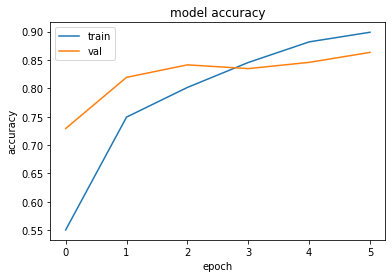

In [ ]:
from matplotlib import pyplot as plt
plt.plot(metrics_history['train_acc'])
plt.plot(metrics_history['valid_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from gap_utils import *

In [ ]:
valid_path = "../../model/data/dev.tsv"
valid_dataset, valid_pron_counter = read_dataset(valid_path)

Counter({'her': 140, 'his': 108, 'he': 93, 'she': 87, 'him': 26})


In [ ]:
def predict(model, sentences: List[Dict], tokenizer, tag_labels, device) -> List[Tuple[Tuple[str, int], Tuple[str, int]]]:
    df = pd.DataFrame(sentences)

    # tokenizer will be self.tokenizer in the final implementation
    dataset = GAP_Dataset(df, tokenizer, tag_labels, labeled=False, cleaned=False)
    collator = Collator(device, labeled=False)

    predictions = []
    
    #self.model.eval()
    model.eval()
    with torch.no_grad():
        dataloader = DataLoader(dataset, batch_size=1, 
                                collate_fn=collator, shuffle=False)
        
        for sample, sentence in zip(dataloader, sentences):
            
            predicted_label_id = model(sample).argmax(1).item()
            pred_entity, pred_entity_offset = get_entity_and_offset_from_id(predicted_label_id, sentence)
            pron, pron_offset = sentence['pron'], sentence['p_offset']
            
            predictions.append(((pron, pron_offset), (pred_entity, pred_entity_offset)))
            
    return predictions
            

In [ ]:
def multi_choice_predict(model, sentences: List[Dict], tokenizer, tag_labels, device) -> List[Tuple[Tuple[str, int], Tuple[str, int]]]:
    df = pd.DataFrame(sentences)

    # tokenizer will be self.tokenizer in the final implementation
    dataset = GAP_Dataset(df, tokenizer, tag_labels, multiple_choice=True, labeled=False, cleaned=False)
    collator = Collator_Multi_Choice(device, labeled=False)

    predictions = []
    
    #self.model.eval()
    model.eval()
    with torch.no_grad():
        dataloader = DataLoader(dataset, batch_size=1, 
                                collate_fn=collator, shuffle=False)
        
        for sample, sentence in zip(dataloader, sentences):
            
            predicted_label_id = model(sample).argmax(1).item()
            pred_entity, pred_entity_offset = get_entity_and_offset_from_id(predicted_label_id, sentence)
            pron, pron_offset = sentence['pron'], sentence['p_offset']
            
            predictions.append(((pron, pron_offset), (pred_entity, pred_entity_offset)))
            
    return predictions
            

In [ ]:
pred = predict(model, valid_dataset, tokenizer, tag_labels, device)

In [ ]:
compute_metrics(pred, valid_dataset)